In [ ]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

from zipfile import ZipFile
! cp '/content/drive/MyDrive/ML_Capstone/drive-download.zip' '/content'
from zipfile import ZipFile
zip = ZipFile('/content/drive-download.zip')
zip.extractall()

Mounted at /content/drive/


In [ ]:
# importing required packages
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
import pandas as pd

# Dataset and Dataloaders

In [ ]:
# Set device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Lazy Loading

data
-train
  - X
    - 1
      - rgb
        - 0.png
        - 1.png
        - 2.png
      - depth.npy
      - field_id.pkl
    
    - 2

    - ...
  - Y
    - 1.npy
    - 2.npy

-test

In [ ]:
class LazyLoadDataset(Dataset):
  def __init__(self,path,train=True,transform=None):
    self.train = train
    self.transform = transform
    path = path + ("train/" if train else "test/")

    self.pathX = path + "X/"
    self.pathY = path + "Y/"

    self.data = os.listdir(self.pathX)

  def __getitem__(self,idx):
    f = self.data[idx]

    # X
    # read rgb images
    img0 = cv2.imread(self.pathX + f + "/rgb/0.png")/255
    #img0 = Image.open(self.pathX + f + "/rgb/0.png")

    if self.transform is not None:
      img0 = self.transform(img0)

    # read field ID
    field_id = pkl.load(open(self.pathX + f + "/field_id.pkl","rb"))

    if self.train==True:
      # Y 
      Y = np.load(self.pathY + f + ".npy")*1000
      return (img0[0].float().type(torch.float32),field_id),torch.from_numpy(Y).float().type(torch.float32)

    else: # if test, there is no Y
      return img0[0].float().type(torch.float32),field_id

  def __len__(self):
    return len(self.data)


#Normalization: Compute Mean and Std

In [ ]:
train_dataset_raw = LazyLoadDataset("/content/",train=True,transform=ToTensor()) 
means=[]
stds=[]
for i in range(3396):
  (img_i, id_i),Y_i=train_dataset_raw[i]
  means.append([torch.mean(img_i).item()])
  stds.append([torch.std(img_i).item()])

In [ ]:
img_i.shape

torch.Size([224, 224])

In [ ]:
means

In [ ]:
norm_mean=np.mean(means,axis =0)
norm_mean = list(norm_mean)
norm_mean

[0.43522507327886295]

In [ ]:
norm_std=np.mean(stds,axis=0)
norm_std = list(norm_std)
norm_std

[0.1991702498400801]

#Train Dataset & Train loader

In [ ]:
#transform=transforms.Compose([transforms.ToTensor()])
train_dataset = LazyLoadDataset("/content/",transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std)]))

In [ ]:
(img0, field_id), Y = train_dataset[0]

In [ ]:
img0.shape

torch.Size([224, 224])

In [ ]:
batch_size_train = 4
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)

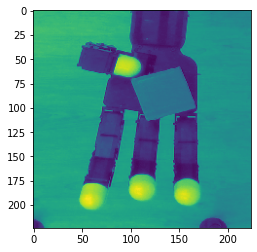

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  plt.imshow(data[0][0])
  break
  

#Test Dataset & Test loader

In [ ]:
test_dataset = LazyLoadDataset("/content/",train=False,transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std),
                   ])) #,transform=transform

batch_size_test = 2
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=True)

# Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        
        # We use Sequential for simplicity
        self.stack = nn.Sequential(nn.Conv2d(input_channels, conv_feature,kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.Conv2d(conv_feature, conv_feature,kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   
                                   nn.Flatten(),
                                   nn.Linear(conv_feature*53*53, fc_feature),
                                   nn.ReLU(),
                                   nn.Linear(fc_feature, output_size)
        )
                 
                                   
                                  
    def forward(self, x):
        x = self.stack(x)
        return x

In [ ]:
# Model input/output settings
input_channels = 1
conv_feature = 6 
fc_feature = 50
output_size=12

In [ ]:
def train(epoch, model, optimizer,loader=train_loader):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        loader: val/train loader
    """
    model.train()
    for batch_idx,((data, id),target) in enumerate(loader):
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.view(len(id),1,224, 224)

        # consider passing different data augmentation in training
        # data = F.invert()
        # data = F.adjust_sharpness(data,sharpness_factor = 0.5)
        # data = F.adjust_hue(data,hue_factor = 0.9)
        # data = F.adjust_saturation(data,saturation_factor = 0.5)

        # make sure we erase all the gradients before computing new ones
        optimizer.zero_grad() 
        
        # forward propagation
        output = model(data)
        #print(output.dtype)

        #RMSE loss
        loss = torch.sqrt(nn.functional.mse_loss(output,target))
        
        # backward propagation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss))
            

In [ ]:
def test(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    ids = []
    preds = []
    with torch.no_grad():
      for batch_idx,(data, id) in enumerate(test_loader):
        # send to device
        data = data.view(len(id),1,224, 224)
        data = data.to(device)          
        pred = model(data)
        for i in range(len(id)):
          ids.append(id[i])
          preds.append(np.array(pred[i].cpu()/1000,dtype="float64"))

    return ids, preds  
    

In [ ]:
def get_n_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Cross-Validation & Grid-Search for determining hyperparameters

What should hyperparameters in the models be? We could perform grid-search on the whole train dataset and pick the best-performing hyerparameters. But to avoid over-fitting on the train dataset, we split the whole train dataset into 9:1.




*   cross_val_train_set (90% of train dataset)
*   cross_val_test_set (10% of train dataset)


We train our model on the cross_val_train_set and test our model on cross_val_test_set. We pick the best-performing hyperparameters on the cross_val_test_set.

After all these steps, we train our model using the picked hyperparameters on the whole train dataset.

In [ ]:
cross_val_train_set, cross_val_test_set = train_test_split(train_dataset, test_size=0.1)

In [ ]:
# Sanity Check
len(cross_val_train_set) == int(len(train_dataset)*0.9)
len(cross_val_train_set)

3056

In [ ]:
batch_size_cross_val_train = 4
batch_size_cross_val_test = len(cross_val_test_set) # = 340
len(cross_val_test_set)

340

In [ ]:
cross_val_train_loader=DataLoader(cross_val_train_set,batch_size=batch_size_cross_val_train,shuffle=True)
cross_val_test_loader=DataLoader(cross_val_test_set,batch_size=batch_size_cross_val_test,shuffle=True)

In [ ]:
len(cross_val_test_loader)

1

In [ ]:
def cross_val(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    # We can just edit on the code for train(). We should delete the bakward propagation part and optimizer part.

    with torch.no_grad():
      for batch_idx,((data, id),target) in enumerate(cross_val_test_loader):
          # send to device
          data = data.view(len(id),1,224, 224)
    
          if batch_idx==0:
            data, target = data.to(device), target.to(device)
            
            # forward propagation
            output = model(data)

            #RMSE loss
            loss = torch.sqrt(nn.functional.mse_loss(output,target)) 
            return loss.item()

In [ ]:
def SGD_hyper_tuning(lr_list,momentum_list):  
  for j in momentum_list:
    for i in lr_list:
      model_cnn = CNN(input_channels, conv_feature, fc_feature, output_size) # create CNN model
      model_cnn.to(device)
      print("lr=",i,"momentum=",j)
      train(epoch=0, model=model_cnn, optimizer=torch.optim.SGD(model_cnn.parameters(), lr=i,momentum=j),loader=cross_val_train_loader)
      print("Validation Performance:",cross_val(model_cnn))

In [ ]:
lr_list = [1e-5,1e-4,1e-3,1e-2,1e-1]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

lr= 1e-05 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 62.734058
Train Epoch: 0 [800/3056 (26%)]	Loss: 47.794487
Train Epoch: 0 [1600/3056 (52%)]	Loss: 23.020435
Train Epoch: 0 [2400/3056 (79%)]	Loss: 17.906036
Validation Performance: 14.188737869262695
lr= 0.0001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 63.419437
Train Epoch: 0 [800/3056 (26%)]	Loss: 21.533598
Train Epoch: 0 [1600/3056 (52%)]	Loss: 13.101376
Train Epoch: 0 [2400/3056 (79%)]	Loss: 15.473317
Validation Performance: 9.985139846801758
lr= 0.001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 64.077415
Train Epoch: 0 [800/3056 (26%)]	Loss: 26.291391
Train Epoch: 0 [1600/3056 (52%)]	Loss: 36.055534
Train Epoch: 0 [2400/3056 (79%)]	Loss: 15.102719
Validation Performance: 18.878028869628906
lr= 0.01 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 67.555946
Train Epoch: 0 [800/3056 (26%)]	Loss: 30.958279
Train Epoch: 0 [1600/3056 (52%)]	Loss: 21.294027
Train Epoch: 0 [2400/3056 (79%)]	Loss: 23.215727
Validati

Top 3 Performance hyperparameters (Results may vary if rerun the program)

1.  lr = 1e-3, momentum = 0.95
2.  lr = 1e-3, momentum = 0.91
3.  lr = 1e-4, momentum = 0.91


In [ ]:
lr_list = [8e-4,9e-4,1e-3,2e-3,3e-3]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

lr= 0.0008 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 67.472572
Train Epoch: 0 [800/3056 (26%)]	Loss: 26.220602
Train Epoch: 0 [1600/3056 (52%)]	Loss: 17.516560
Train Epoch: 0 [2400/3056 (79%)]	Loss: 12.981943
Validation Performance: 12.304163932800293
lr= 0.0009 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 66.792900
Train Epoch: 0 [800/3056 (26%)]	Loss: 19.911768
Train Epoch: 0 [1600/3056 (52%)]	Loss: 17.435802
Train Epoch: 0 [2400/3056 (79%)]	Loss: 16.574356
Validation Performance: 21.38776206970215
lr= 0.001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 70.199600
Train Epoch: 0 [800/3056 (26%)]	Loss: 19.550425
Train Epoch: 0 [1600/3056 (52%)]	Loss: 17.886932
Train Epoch: 0 [2400/3056 (79%)]	Loss: 14.010690
Validation Performance: 12.412755012512207
lr= 0.002 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 67.959297
Train Epoch: 0 [800/3056 (26%)]	Loss: 47.214111
Train Epoch: 0 [1600/3056 (52%)]	Loss: 27.155489
Train Epoch: 0 [2400/3056 (79%)]	Loss: 26.134819
Valida

Top 1 Performance

lr = 1e-3, momentum = 0.93

# lr=1e-3, momentum=0.95, 20 epoch, train_batch_size = 4, no lr decay

In [ ]:
model_cnn = CNN(input_channels, conv_feature, fc_feature, output_size) # create Cnn model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-3,momentum=0.93) 

print("lr=",1e-3,"momentum=",0.93)
for epoch in range(20):
  train(epoch, model=model_cnn, optimizer=torch.optim.SGD(model_cnn.parameters(), lr=1e-3,momentum=0.93),loader=train_loader)


lr= 0.001 momentum= 0.93
Train Epoch: 0 [0/3396 (0%)]	Loss: 64.462250
Train Epoch: 0 [800/3396 (24%)]	Loss: 17.337210
Train Epoch: 0 [1600/3396 (47%)]	Loss: 8.072540
Train Epoch: 0 [2400/3396 (71%)]	Loss: 7.703561
Train Epoch: 0 [3200/3396 (94%)]	Loss: 8.872863
Train Epoch: 1 [0/3396 (0%)]	Loss: 8.076866
Train Epoch: 1 [800/3396 (24%)]	Loss: 8.425791
Train Epoch: 1 [1600/3396 (47%)]	Loss: 6.908237
Train Epoch: 1 [2400/3396 (71%)]	Loss: 6.287788
Train Epoch: 1 [3200/3396 (94%)]	Loss: 5.780176
Train Epoch: 2 [0/3396 (0%)]	Loss: 7.924293
Train Epoch: 2 [800/3396 (24%)]	Loss: 8.264155
Train Epoch: 2 [1600/3396 (47%)]	Loss: 6.830966
Train Epoch: 2 [2400/3396 (71%)]	Loss: 5.226965
Train Epoch: 2 [3200/3396 (94%)]	Loss: 6.281268
Train Epoch: 3 [0/3396 (0%)]	Loss: 4.581614
Train Epoch: 3 [800/3396 (24%)]	Loss: 6.388758
Train Epoch: 3 [1600/3396 (47%)]	Loss: 9.249502
Train Epoch: 3 [2400/3396 (71%)]	Loss: 5.060168
Train Epoch: 3 [3200/3396 (94%)]	Loss: 4.171536
Train Epoch: 4 [0/3396 (0%)]	Loss

In [ ]:
torch.save(model_cnn,'/content/drive/MyDrive/ML_Capstone/v1_cnn_1img0_m1.pt')
model_cnn = torch.load('/content/drive/MyDrive/ML_Capstone/v1_cnn_1img0_m1.pt')
model_cnn.eval()

ids,preds = test(model_cnn)

outfile = '/content/drive/MyDrive/ML_Capstone/submission_v1_cnn_1img0_m1.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']

df = pd.concat([pd.DataFrame(ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file /content/drive/MyDrive/ML_Capstone/submission_v1_cnn_1img0_m1.csv
